In [1]:
# Importing packages
from time import time
from cupyx.time import repeat
import numpy as np
import cupy as cp
from numba import njit
import ruptures as rpt
from pychange.numba_costs import normal_mean_var_cost as aot_normal_mean_var_cost
from pychange.numba_costs import scalar_normal_mean_var_cost as aot_scalar_normal_mean_var_cost
from pychange.gpu.costs import normal_mean_var_cost as gpu_normal_mean_var_cost
from pychange.gpu.preprocess import create_summary_stats as gpu_create_summary_stats
from pychange.gpu.segment import pelt as gpu_pelt
from pychange.costs import normal_mean_var_cost, ParametricCost
from pychange.segment import create_summary_stats, pelt
import matplotlib.pyplot as plt

# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects

# import R's utility package
utils = rpackages.importr('utils')
rcp = rpackages.importr('changepoint')

In [2]:
# Creating test data
n_total = np.logspace(1.5, 3.5, num=5)
def make_test_series(x):
    return np.hstack([np.random.normal(0, 1, (25 * x,)),
                      np.random.normal(1, 1, (25 * x,)),
                      np.random.normal(-3, 2, (25 * x,)),
                      np.random.normal(1, 1, (25 * x,))])
test_series = [make_test_series(int(i)) for i in n_total]
r_series = [robjects.FloatVector(np.array(i)) for i in test_series]

In [9]:
# Storing results
results = {'r': [], 'ruptures': [], 'pychange': [], 'pychange_aot': []}

In [10]:
# Pychange (AOT)
for i in test_series:
    start_time = time()
    _ = pelt(i, 30, 100, create_summary_stats, aot_normal_mean_var_cost)
    results['pychange_aot'].append(time() - start_time)
    print(results['pychange_aot'])

[0.16297221183776855]
[0.16297221183776855, 0.6442971229553223]
[0.16297221183776855, 0.6442971229553223, 3.103067398071289]
[0.16297221183776855, 0.6442971229553223, 3.103067398071289, 19.798035621643066]
[0.16297221183776855, 0.6442971229553223, 3.103067398071289, 19.798035621643066, 162.92477464675903]


In [5]:
# Jitting sum stats
jit_sum_stats = njit(fastmath=True)(create_summary_stats)
sum_stats = jit_sum_stats(test_series[0])

# Jitting cost function
jit_normal_mean_var_cost = njit(fastmath=True)(normal_mean_var_cost)
_ = jit_normal_mean_var_cost(sum_stats)

# Jitting segmentation function
jit_pelt = njit(fastmath=True)(pelt)
_ = jit_pelt(test_series[0], 30, 100, jit_sum_stats, jit_normal_mean_var_cost)

In [ ]:
# Pychange
for i in test_series:
    start_time = time()
    _ = jit_pelt(i, 30, 100, jit_sum_stats, jit_normal_mean_var_cost)
    results['pychange'].append(time() - start_time)
    print(results['pychange'])

In [ ]:
# R changepoint benchmark
for i in r_series:
    start_time = time()
    _ = rcp.cpt_meanvar(i, penalty="Manual", pen_value=100, method='PELT', test_stat='Normal')
    results['r'].append(time() - start_time)
    print(results['r'])

[0.07884097099304199]
[0.07884097099304199, 0.8422350883483887]
[0.07884097099304199, 0.8422350883483887, 6.455239295959473]
[0.07884097099304199, 0.8422350883483887, 6.455239295959473, 63.998488903045654]


Exception ignored from cffi callback <function _callback at 0x0000020F7246B040>:
Traceback (most recent call last):
  File "C:\Users\gursk\anaconda3\envs\pychange\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 313, in _callback
    try:
KeyboardInterrupt: 


In [7]:
# Ruptures
for i in test_series:
    start_time = time()
    _ = rpt.Pelt(custom_cost=ParametricCost(cost_fn=aot_scalar_normal_mean_var_cost)).fit(i).predict(pen=100)
    results['ruptures'].append(time() - start_time)

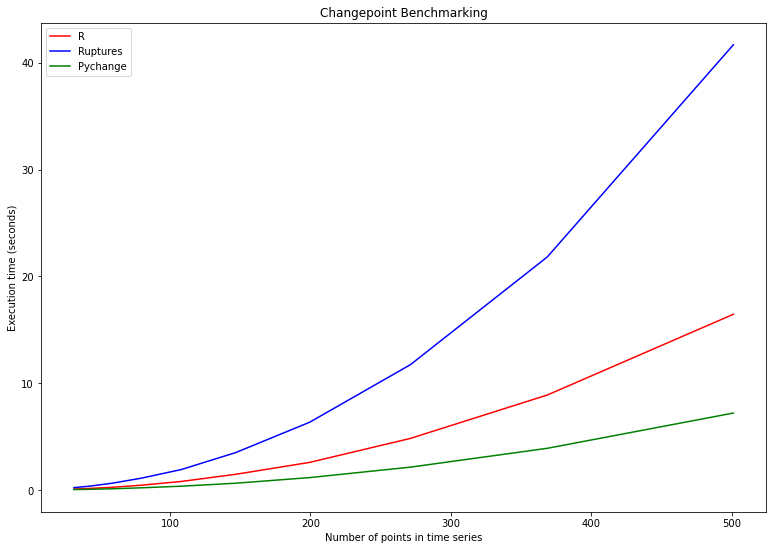

In [18]:
# Plotting results
plt.figure(figsize=(13, 9))
plt.plot(n_total, results['r'], color='red', label='R')
plt.plot(n_total, results['ruptures'], color='blue', label='Ruptures')
plt.plot(n_total, results['pychange'], color='green', label='Pychange')
plt.title('Changepoint Benchmarking')
plt.xlabel('Number of points in time series')
plt.ylabel('Execution time (seconds)')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Plotting results
plt.figure(figsize=(13, 9))
plt.plot(n_total, results['r'], color='red', label='R')
#plt.plot(n_total, results['pychange'], color='blue', label='Ruptures')
plt.plot(n_total, results['pychange_aot'], color='green', label='Pychange (AOT)')
plt.title('Changepoint Benchmarking')
plt.xlabel('Number of points in time series')
plt.ylabel('Execution time (seconds)')
plt.legend(loc='upper left')
plt.show()

In [13]:
# Cupy
test_series = make_test_series(100000)
sum_stats = create_summary_stats(test_series)
cp_sum_stats = cp.asarray(np.float32(sum_stats))

In [14]:
%timeit normal_mean_var_cost(sum_stats)

264 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print(repeat(normal_mean_var_cost, (sum_stats,), name='python', n_repeat=10))  

python              :    CPU:271612.040 us   +/-19627.472 (min:254944.300 / max:320177.000) us     GPU-0:271784.268 us   +/-19640.472 (min:255033.630 / max:320364.929) us


In [16]:
%timeit aot_normal_mean_var_cost(sum_stats)

125 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
print(repeat(aot_normal_mean_var_cost, (sum_stats,), name='numba', n_repeat=10))  

numba               :    CPU:124012.140 us   +/-1787.809 (min:122761.500 / max:129031.900) us     GPU-0:124204.097 us   +/-1863.304 (min:122849.281 / max:129488.739) us


In [18]:
%timeit gpu_normal_mean_var_cost(cp_sum_stats) 

190 µs ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(repeat(gpu_normal_mean_var_cost, (cp_sum_stats,), name='gpu', n_repeat=10)) 

gpu                 :    CPU:  187.850 us   +/-33.310 (min:  167.000 / max:  260.200) us     GPU-0: 4305.891 us   +/-91.654 (min: 4222.976 / max: 4466.560) us


In [ ]:
%timeit gpu_cost(cp_sum_stats) 

In [ ]:
print(repeat(gpu_cost, (cp_sum_stats,), name='gpu', n_repeat=10)) 

In [7]:
%timeit pelt(test_series[2], 30, 100, create_summary_stats, aot_normal_mean_var_cost)

3.04 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
def gpu_pelt(x, min_len, penalty, preprocess_fn, cost_fn):
    """Pruned exact linear time changepoint segmentation"""
    
    # Setting up summary statistics and objects
    n = x.shape[0]
    sum_stats = cp.asarray(preprocess_fn(x))
    
    # Initializing pelt parameters
    f = np.empty(shape=(n,), dtype=np.float64)
    f[0] = -penalty
    costs = np.empty(shape=(n,), dtype=np.float64)
    #cp = np.array([np.array([], dtype=np.int32)], dtype=object)
    cps = np.zeros(shape=(n, 1), dtype=cp.bool8)
    r = np.array([0])
    
    
    # Entering main loop
    for tau_star in np.arange(1, n):
        
        # Calculating minimum segment cost
        costs[r] = cost_fn(sum_stats[tau_star] - sum_stats[r]).get()
        _costs = costs[r] + f[r] + penalty
        
        f[tau_star] = _costs.min()
        tau_l = r[np.argmin(_costs)]
        
        # Setting new changepoints
        _cps = cps[:, np.array([tau_l])].copy()
        _cps[tau_l, :] = True
        cps = np.concatenate((cps, _cps), axis=1)
        #cp = np.append(cp, np.append(cp[tau_l], np.array([tau_l], dtype=np.int32)))
        
        # Setting new candidate points
        r = r[(f[r] + costs[r] + penalty) <= f[tau_star]]
        cps = cps[:, r]
        r = np.append(r, tau_star)
        
    return cps[:, -1]

In [9]:
#gpu_series = cp.asarray(test_series[2])
%prun gpu_pelt(test_series[0], 30, 100, create_summary_stats, gpu_normal_mean_var_cost)